In [1]:
!nvidia-smi

Wed Jun 30 01:58:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install matplotlib
# !pip install tqdm
# !pip install tensorflow
# !pip install tensorflow-addons
# !pip install tfds-nightly

In [3]:
# import os
# import shutil
# fro = '../input/celeba/celeb_a/2.0.1/'
# to = '/root/tensorflow_datasets/celeb_a/2.0.1/'

In [4]:
# shutil.copytree(fro, to)

In [5]:
# os.listdir(to)

In [6]:
import numpy as np
import pandas as pd
import copy, time, sys, os
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
from tensorflow.keras import backend as kb

# Define Blocks

In [7]:
class encoder_block(layers.Layer):
    def __init__(self, filters, kernel_size, strides, name='encoder_block', **kwargs):
        super(encoder_block, self).__init__(name=name, **kwargs)
        self.layer0 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides)
        self.layer1 = layers.BatchNormalization()
        self.layer2 = layers.LeakyReLU()
    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [8]:
class decoder_block(layers.Layer):
    def __init__(self, filters, kernel_size, strides, name='decoder_block', **kwargs):
        super(decoder_block, self).__init__(name=name, **kwargs)
        self.layer0 = layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides)
        self.layer1 = layers.BatchNormalization()
        self.layer2 = layers.ReLU()
    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [9]:
class d_c_block(layers.Layer):
    def __init__(self, filters, kernel_size, strides, name='d_c_block', **kwargs):
        super(d_c_block, self).__init__(name=name, **kwargs)
        self.layer0 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides)
        self.layer1 = tfa.layers.InstanceNormalization(axis=-1)
        self.layer2 = layers.LeakyReLU()

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer2(x)
        return x

# Create Models

In [10]:
class Encoder_G(keras.Model):
    def __init__(self, name="encoder_g", **kwargs):
        super(Encoder_G, self).__init__(name=name, **kwargs)
        self.layer0 = encoder_block(filters=64, kernel_size=5, strides=2)
        self.layer1 = encoder_block(filters=128, kernel_size=5, strides=2)
        self.layer2 = encoder_block(filters=256, kernel_size=5, strides=2)
        self.layer3 = encoder_block(filters=512, kernel_size=5, strides=2)

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [11]:
class Decoder_G(keras.Model):
    def __init__(self, name="decoder_g", **kwargs):
        super(Decoder_G, self).__init__(name=name, **kwargs)
        self.layer0 = decoder_block(filters=512, kernel_size=5, strides=2)
        self.layer1 = decoder_block(filters=256, kernel_size=5, strides=2)
        self.layer2 = decoder_block(filters=128, kernel_size=5, strides=2)
        self.layer3 = decoder_block(filters=64, kernel_size=5, strides=2)
        self.layer4 = layers.Conv2DTranspose(3, 4, 1, activation='sigmoid')

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [12]:
class D_C(keras.Model):
    def __init__(self, name="d_c", **kwargs):
        super(D_C, self).__init__(name=name, **kwargs)
        self.layer0 = d_c_block(filters=64, kernel_size=3, strides=1)
        self.layer1 = d_c_block(filters=64, kernel_size=5, strides=2)
        self.layer2 = d_c_block(filters=128, kernel_size=5, strides=2)
        self.layer3 = d_c_block(filters=256, kernel_size=5, strides=2)
        self.layer4 = d_c_block(filters=512, kernel_size=5, strides=2)
        self.layer5 = d_c_block(filters=512, kernel_size=1, strides=1)

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [13]:
class D(keras.Model):
    def __init__(self, name="d", **kwargs):
        super(D, self).__init__(name=name, **kwargs)
        self.layer0 = layers.Dense(1024)
        # self.layer1 = tfa.layers.InstanceNormalization()
        self.layer1 = layers.LeakyReLU()
        self.layer2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [14]:
class C(keras.Model):
    def __init__(self, name="c", **kwargs):
        super(C, self).__init__(name=name, **kwargs)
        self.layer0 = layers.Dense(1024)
        # self.layer1 = tfa.layers.InstanceNormalization()
        self.layer1 = layers.LeakyReLU()
        self.layer2 = layers.Dense(40, activation='sigmoid')

    def call(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [15]:
decoder_g = Decoder_G()
encoder_g = Encoder_G()
d_c = D_C()
d = D()
c = C()

# Define Some Values

In [16]:
batch_size = 32
lr = 0.0002
lambda_1 = 100
lambda_2 = 10
lambda_3 = 1
B1 = 0.5
B2 = 0.999

# Get Data

In [17]:
def normalize_img(feature):
  """Normalizes images: `uint8` -> `float32`."""
  feature['image'] = tf.cast(feature['image'], tf.float32) / 255
  feature['image'] = tf.image.resize(feature['image'], (64, 64))
  return feature

## Load Data

In [18]:
train_ds, val_ds, test_ds = tfds.load('celeb_a', split=['train', 'validation', 'test'], shuffle_files=True)

## Prepare Images To Size And Normalize

In [19]:
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Batch Data

### Train Dataset

In [20]:
train_batches = train_ds.batch(batch_size)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

### Validation Dataset

In [21]:
val_batches = val_ds.batch(batch_size)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

### Test Dataset

In [22]:
test_batches = test_ds.batch(batch_size)
test_batches = test_batches.prefetch(tf.data.experimental.AUTOTUNE)

### Delete Unwanted Variables

In [23]:
del train_ds, test_ds, val_ds

# Define Certain Loss Functions & Classes

In [24]:
class LADV_D(keras.losses.Loss):
    def call(self, d_xa, d_xb_cap):
        d_xa = tf.convert_to_tensor(d_xa)
        d_xb_cap = tf.cast(d_xb_cap, d_xa.dtype)
        return ((-1 * tf.reduce_mean(d_xa)) + tf.reduce_mean(d_xb_cap))

In [25]:
class LADV_G(keras.losses.Loss):
    def call(self, d_xb_cap, a=None):
        d_xb_c = tf.cast(d_xb_cap, tf.float32)
        return -1 * tf.reduce_mean(d_xb_cap)

In [26]:
mae = keras.losses.MeanAbsoluteError()
bce = keras.losses.BinaryCrossentropy()
ladvd = LADV_D()
ladvg = LADV_G()

In [27]:
opt_enc_G = keras.optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)
opt_dec_G = keras.optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)
opt_D_C = keras.optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)
opt_D = keras.optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)
opt_C = keras.optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)

In [28]:
@tf.function
def train_step(xa, a, b):
    # encode image
    z = encoder_g(xa)
    # add attributes to encoding
    z_b = tf.concat([z, b], axis=-1)
    # decode the resulting tensor into an image
    xb_cap = decoder_g(z_b)

    # Update Discriminator
    with tf.GradientTape() as d_c_tape:
        dc = d_c(xb_cap)
        da = d_c(xa)
        with tf.GradientTape() as d_tape:
            d_xb_cap = d(dc)
            d_xa = d(da)
            # ldt = bce(np.ones(d_xa.shape), d_xa)
            # ldf = bce(np.zeros(d_xb_cap.shape), d_xb_cap)
            ld = ladvd(d_xa, d_xb_cap)
        grads = d_tape.gradient(ld, d.trainable_weights)
        opt_D.apply_gradients(zip(grads, d.trainable_weights))

        with tf.GradientTape() as c_tape:
            a_cap = c(da)
            lc = bce(a, a_cap)
        ldc = ld + lc
        grads = c_tape.gradient(lc, c.trainable_weights)
        opt_C.apply_gradients(zip(grads, c.trainable_weights))
    grads = d_c_tape.gradient(ldc, d_c.trainable_weights)
    opt_D_C.apply_gradients(zip(grads, d_c.trainable_weights))

    # Update Generator
    with tf.GradientTape() as enc_tape:
        z = encoder_g(xa)
        z_a = tf.concat([z, a], axis=-1)
        z_b = tf.concat([z, b], axis=-1)
        with tf.GradientTape() as dec_tape:
            xa_cap = decoder_g(z_a)
            lgr = mae(xa, xa_cap)
            xb_cap = decoder_g(z_b)
            dc_xb = d_c(xb_cap)
            b_cap = c(dc_xb)
            lgc = bce(b, b_cap)
            lgc = tf.cast(lgc, tf.float32)
            d_xb_cap = d(dc_xb)
            lga = ladvg(d_xb_cap, a)
            lg = lambda_1*lgr
            lg += lga
            lg += lambda_2*lgc
            # print(lgr.numpy(), lgc.numpy(), lga.numpy())
        # if lg.numpy() > 0:
        grads = dec_tape.gradient(lg, decoder_g.trainable_weights)
        opt_dec_G.apply_gradients(zip(grads, decoder_g.trainable_weights))
    # if lg.numpy() > 0:
    grads = enc_tape.gradient(lg, encoder_g.trainable_weights)
    opt_enc_G.apply_gradients(zip(grads, encoder_g.trainable_weights))
    return lg, ldc

In [29]:
@tf.function
def val_step(xa, a, b):
    z = encoder_g(xa)
    z_a = tf.concat([z, a], axis=-1)
    b = np.round(np.random.rand(a.shape[0], a.shape[1], a.shape[2], a.shape[3]))
    z_b = tf.concat([z, b], axis=-1)
    xa_cap = decoder_g(z_a)
    xb_cap = decoder_g(z_b)
    dc_xb_cap = d_c(xb_cap)
    dc_xa = d_c(xa)
    d_xa = d(dc_xa)
    d_xb_cap = d(dc_xb_cap)
    a_cap = c(dc_xa)
    b_cap = c(dc_xb_cap)
    tld = ladvd(d_xa, d_xb_cap) + bce(a, a_cap)
    tlg = lambda_1*mae(xa, xa_cap)+lambda_2*tf.cast(bce(b, b_cap), tf.float32)+ladvg(d_xb_cap, a)
    return tlg, tld

# Plotting

In [30]:
# fig_g = go.FigureWidget()
# fig_g.add_scatter(name='trn_g')
# fig_g.add_scatter(name='val_g')
# fig_g

In [31]:
# fig_d = go.FigureWidget()
# fig_d.add_scatter(name='trn_d')
# fig_d.add_scatter(name='val_d')
# fig_d

In [32]:
epochs = 1000
history = {}
metrics_names = ['trn_gen_loss', 'trn_dis_loss', 'val_gen_loss', 'val_dis_loss']
for i in metrics_names:
    history[i] = []
for epoch in range(epochs):
    print("\nepoch {}/{}".format(epoch+1,epochs))
    progBar = Progbar(len(train_batches), stateful_metrics=metrics_names)
    for step, batch in enumerate(train_batches):

        a = batch['attributes']
        xa = tf.cast(batch['image'], tf.float32)
        a = np.array([a[key] for key in a.keys()]).T
        a = tf.cast(np.reshape(a, [a.shape[0], 1, 1, a.shape[1]]), tf.float32)
        b = tf.cast(np.round(np.random.rand(a.shape[0], a.shape[1], a.shape[2], a.shape[3])), tf.float32)

        ## Train!!!
        lg, ldc = train_step(xa, a, b)
        
        ## Validation!!!
        choice = np.random.randint(len(val_batches), size=1)[0]
        i = 0
        for batch in val_batches:
            if i == choice:
                break
            i += 1
        a = batch['attributes']
        xa = tf.cast(batch['image'], tf.float32)
        a = np.array([np.array(a[key]) for key in a.keys()], dtype='float32').T
        a = tf.cast(np.reshape(a, (a.shape[0], 1, 1, a.shape[1])), tf.float32)
        b = tf.cast(np.round(np.random.rand(a.shape[0], a.shape[1], a.shape[2], a.shape[3])), tf.float32)

        tlg, tld = val_step(xa, a, b)
        
        values = [('trn_gen_loss', lg.numpy()), ('trn_dis_loss', ldc.numpy()), ('val_gen_loss', tlg.numpy()), ('val_dis_loss', tld.numpy())]

        for i in values:
            history[i[0]].append(i[1])
        
        ## Plotting
        # fig_g.data[0].y = history['trn_gen_loss']
        # fig_g.data[1].y = history['val_gen_loss']
        # fig_d.data[0].y = history['trn_dis_loss']
        # fig_d.data[1].y = history['val_dis_loss']

        progBar.update(step+1, values=values)
    
    ## Save Models
    d.save('D')
    c.save('C')
    d_c.save('D_C')
    encoder_g.save('Encoder')
    decoder_g.save('Decoder')
    ## Save Optimizers
    np.save('opt_c', opt_C.get_weights())
    np.save('opt_d', opt_D.get_weights())
    np.save('opt_dc', opt_D_C.get_weights())
    np.save('opt_enc', opt_enc_G.get_weights())
    np.save('opt_dec', opt_dec_G.get_weights())


epoch 1/1000
   2/5087 [..............................] - ETA: 45:00 - trn_gen_loss: 30.5830 - trn_dis_loss: 0.6782 - val_gen_loss: 31.4699 - val_dis_loss: 0.6426   

KeyboardInterrupt: 

In [34]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
d.save('D')
c.save('C')
d_c.save('D_C')
encoder_g.save('Encoder')
decoder_g.save('Decoder')
print("hello")

INFO:tensorflow:Assets written to: D\assets
INFO:tensorflow:Assets written to: D\assets
INFO:tensorflow:Assets written to: C\assets
INFO:tensorflow:Assets written to: C\assets
INFO:tensorflow:Assets written to: D_C\assets
INFO:tensorflow:Assets written to: D_C\assets
INFO:tensorflow:Assets written to: Encoder\assets
INFO:tensorflow:Assets written to: Encoder\assets
INFO:tensorflow:Assets written to: Decoder\assets
INFO:tensorflow:Assets written to: Decoder\assets
hello


In [37]:
np.save('opt_c', opt_C.get_weights())
np.save('opt_d', opt_D.get_weights())
np.save('opt_dc', opt_D_C.get_weights())
np.save('opt_enc', opt_enc_G.get_weights())
np.save('opt_dec', opt_dec_G.get_weights())

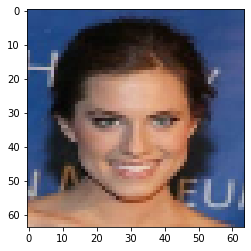

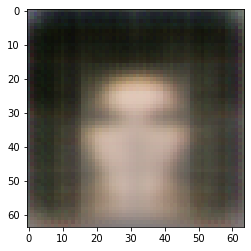

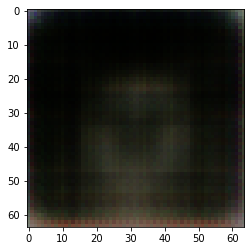

In [46]:
z = encoder_g(xa)
z_a = tf.concat([z, a], axis=-1)
z_b = tf.concat([z, b], axis=-1)
xa_cap = decoder_g(z_a)
xb_cap = decoder_g(z_b)
plt.imshow(xa[0])
plt.show()
plt.imshow(xa_cap[0])
plt.show()
plt.imshow(xb_cap[0])
plt.show()

In [56]:
tlg, tld = 0, 0

In [57]:
for i, batch in enumerate(tqdm(test_batches)):
    a = batch['attributes']
    xa = batch['image']
    a = np.array([np.array(a[key]) for key in a.keys()], dtype='float32').T
    a = np.reshape(a, (a.shape[0], 1, 1, a.shape[1]))
    b = np.round(np.random.rand(a.shape[0], a.shape[1], a.shape[2], a.shape[3]))
    z = encoder_g(xa)
    z_a = tf.concat([z, a], axis=-1)
    b = np.round(np.random.rand(a.shape[0], a.shape[1], a.shape[2], a.shape[3]))
    z_b = tf.concat([z, b], axis=-1)
    del z
    xa_cap = decoder_g(z_a)
    del z_a
    xb_cap = decoder_g(z_b)
    del z_b
    dc_xb_cap = d_c(xb_cap)
    del xb_cap
    dc_xa = d_c(xa)
    d_xa = d(dc_xa)
    d_xb_cap = d(dc_xb_cap)
    a_cap = c(dc_xa)
    b_cap = c(dc_xb_cap)
    del dc_xa, dc_xb_cap
    tld += ladvd(d_xa, d_xb_cap) + bce(a, a_cap)
    tlg += lambda_1*mae(xa, xa_cap)+lambda_2*tf.cast(bce(b, b_cap), tf.float32)+ladvg(d_xb_cap, a)


100%|██████████| 624/624 [01:10<00:00,  8.81it/s]


In [58]:
tlg /= len(test_batches)
tld /= len(test_batches)
tlg.numpy(), tld.numpy()

(<tf.Tensor: shape=(), dtype=float32, numpy=22.96448>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.37587577>)